# Covid Analysis

This notebook analyzes the US Covid data from this web site: [The Covid Tracker: Data](https://covidtracking.com/data/download).  the data definitions can be found on a page linked form that initial page: [The Covid Tracker: Data Definition](https://covidtracking.com/about-data/data-definitions).

The first level of analysis is to performa a moving average to find the 'average' shape of the curve for number of new cases, which is indicated by the field name <font face='courier'>positiveIncrease</font>.

This example is for illustration of a data analysis and so, to save a bit of effort we will not worry about formatting the x-axis tickmark labels for clarity.

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

## Data Input with <font face='courier'>pandas</font>

In [4]:
df = pd.read_csv('national-history.csv')
df.head()

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,states,totalTestResults,totalTestResultsIncrease
0,2021-03-07,515151.0,842,45475.0,8134.0,726,40199.0,776361.0,74582825.0,131835,4281.0,2802.0,28756489.0,41835,56,363825123,1170059
1,2021-03-06,514309.0,1680,45453.0,8409.0,503,41401.0,775635.0,74450990.0,143835,4280.0,2811.0,28714654.0,60015,56,362655064,1430992
2,2021-03-05,512629.0,2221,45373.0,8634.0,2781,42541.0,775132.0,74307155.0,271917,4275.0,2889.0,28654639.0,68787,56,361224072,1744417
3,2021-03-04,510408.0,1743,45293.0,8970.0,1530,44172.0,772351.0,74035238.0,177957,4267.0,2973.0,28585852.0,65487,56,359479655,1590984
4,2021-03-03,508665.0,2449,45214.0,9359.0,2172,45462.0,770821.0,73857281.0,267001,4260.0,3094.0,28520365.0,66836,56,357888671,1406795


In [5]:
df_nc = df[['date', 'positiveIncrease']]
df_nc.head()

,date,positiveIncrease
0,2021-03-07,41835
1,2021-03-06,60015
2,2021-03-05,68787
3,2021-03-04,65487
4,2021-03-03,66836


In [6]:
df_nc.dtypes

date                object
positiveIncrease     int64
dtype: object

Let's re-index the data so that it is from earliest to latest date chronologially, and then look at it.

In [7]:
df_nc = df_nc.reindex(index=df_nc.index[::-1])
df_nc.reset_index(inplace=True, drop=True)
df_nc.head()

,date,positiveIncrease
0,2020-01-13,0
1,2020-01-14,0
2,2020-01-15,0
3,2020-01-16,0
4,2020-01-17,0


Visualize the data.  What patterns or characteristics do you see?

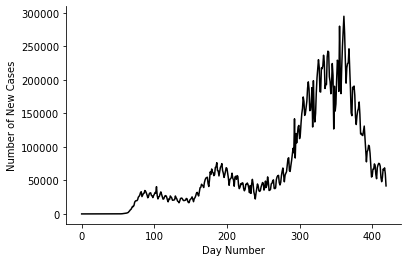

In [9]:
fig,ax = plt.subplots()
ax.plot(df_nc.index, df_nc.positiveIncrease, c='k')
ax.set_xlabel('Day Number')
ax.set_ylabel('Number of New Cases')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.vlines(100, 0, 75000, linestyles='dashed', colors=['gray'])
plt.show()

Next:

- Let's compute and view a moving average to determine the overall average trend.
- Then, subtract the trend from the original data to compute and view the remainder.  Are there obvious patterns in the remainder?

The <font face='courier'>pandas</font> <font face='courier'>.rolling()</font> method picks out a series of rolling windows of specified length, jsut as we need for a moving average.  Applying <font face='courier'>.mean()</font> computes the average of each successive window.

The idea here is to try multiple windows lengths until the window length is found that provides the best fit for the data as measured by sum of squared differences between the moving average and the data.  Notice that, as we discussed in class earlier, applying a moving average causes a decreased number of data points as is represented by the <font face='courier'>NaN</font> (not a number, null) values.

In [26]:
mv_avg = df_nc.positiveIncrease.rolling(20, center=False).mean()
mv_avg.head(n=25)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19    0.10
20    0.10
21    0.15
22    0.15
23    0.15
24    0.25
Name: positiveIncrease, dtype: float64

Compute moving averages with <font face='courier'>pandas</font> <font face='courier'>.rolling()</font> method, insert it into the <font face='courier'>DataFrame</font> and, subsequently, compute the first residual.

In [112]:
mv_avg_period = 15
df_nc['mv_avg'] = df_nc.positiveIncrease.rolling(mv_avg_period, center = True).mean()
df_nc['R1'] = df_nc.positiveIncrease - df_nc.mv_avg
df_nc.R1.iloc[mv_avg_period : mv_avg_period + 10]

15   -0.133333
16   -0.066667
17   -0.200000
18   -0.200000
19   -0.200000
20   -0.200000
21    0.800000
22   -0.200000
23   -0.200000
24    1.733333
Name: R1, dtype: float64

Compute sum of squared errors of current residual as an indication of fit.

In [113]:
print('Sum of Squared Errors: %e' % (df_nc.R1**2).sum())

Sum of Squared Errors: 6.069015e+10


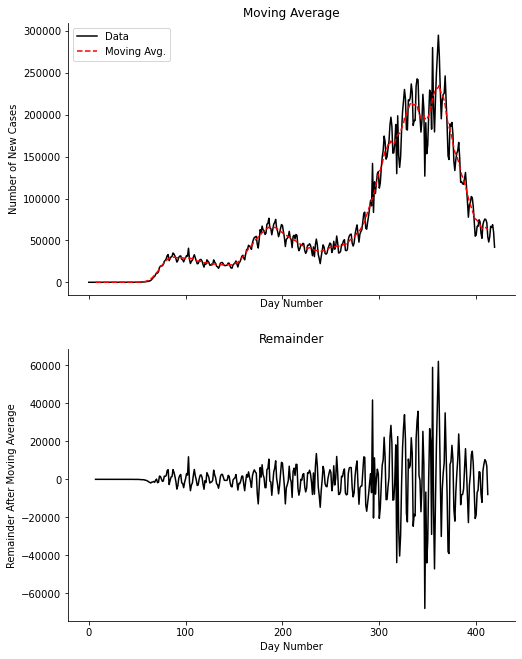

In [114]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(df_nc.index,df_nc.positiveIncrease, c='k', label='Data')
ax[0].plot(df_nc.index, df_nc.mv_avg, c='r', linestyle='--', label='Moving Avg.')
ax[0].set_xlabel('Day Number')
ax[0].set_ylabel('Number of New Cases')
#ax[0].vlines(100, ax[0].get_ylim()[0],  ax[0].get_ylim()[1], linestyles='dashed', colors=['gray'])
#ax[0].vlines(190, ax[0].get_ylim()[0],  ax[0].get_ylim()[1], linestyles='dashed', colors=['gray'])
ax[0].legend()
ax[0].set_title('Moving Average')
ax[1].plot(df_nc.index, df_nc.R1, c='k')
ax[1].set_xlabel('Day Number')
ax[1].set_ylabel('Remainder After Moving Average')
ax[1].set_title('Remainder')
for i in range(len(ax)):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
fig.set_size_inches(8,11)
plt.show()

# A Linear Trend Model

In [115]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print('intercept =', intercept, '    slope =', slope, '     p_value = ',p_value)

intercept = -8374.700942661962     slope = 457.0577834240787      p_value =  1.5033112874127083e-61


In [116]:
df_nc['regress'] = intercept + slope * df_nc.index
df_nc['R1_lin_trend'] = df_nc.positiveIncrease - df_nc.regress
print('Sum of Squared Errors: %e' % (df_nc.R1_lin_trend**2).sum())

Sum of Squared Errors: 9.919296e+11


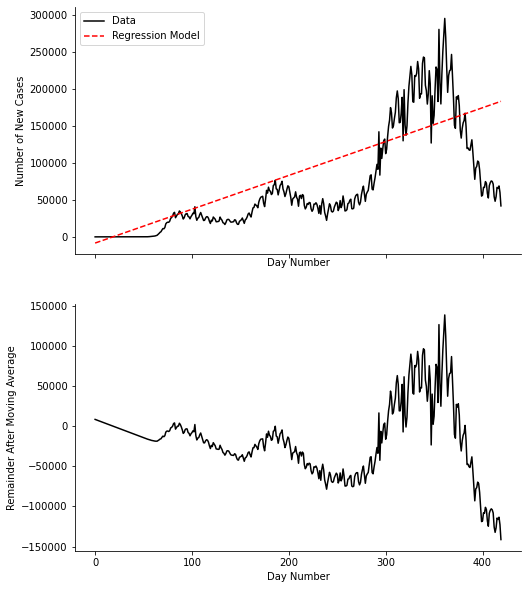

In [117]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(df_nc.index, df_nc.positiveIncrease, c='k', label='Data')
ax[0].plot(df_nc.index,df_nc.regress, c='r', linestyle='--', label='Regression Model')
ax[0].set_xlabel('Day Number')
ax[0].set_ylabel('Number of New Cases')
#ax[0].vlines(100, ax[0].get_ylim()[0],  ax[0].get_ylim()[1], linestyles='dashed', colors=['gray'])
#ax[0].vlines(190, ax[0].get_ylim()[0],  ax[0].get_ylim()[1], linestyles='dashed', colors=['gray'])
ax[0].legend()
ax[1].plot(df_nc.index, df_nc.R1_lin_trend,c='k')
ax[1].set_xlabel('Day Number')
ax[1].set_ylabel('Remainder After Moving Average')
for i in range(len(ax)):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
fig.set_size_inches(8,10)
plt.show()

## Autocorrelation Analysis (with nonlinear model)

The results below demonstrate a clear pattern of 7-day cyclicality.  What might be causing it?

Note that a period of 7 days is consistent with a weekly repeating cyclicality.  One issue with computing this cyclicality is that the magnitude of the current remainder is not of a constant magnitude.

In [120]:
for i in range(1,21):
    print('Correlation with lag %d:  %7.5f' % (i,df_nc['R1'].autocorr(lag = i)))

Correlation with lag 1:  0.29947
Correlation with lag 2:  -0.05468
Correlation with lag 3:  -0.30172
Correlation with lag 4:  -0.36961
Correlation with lag 5:  -0.21957
Correlation with lag 6:  0.17882
Correlation with lag 7:  0.40631
Correlation with lag 8:  0.16009
Correlation with lag 9:  -0.16714
Correlation with lag 10:  -0.26373
Correlation with lag 11:  -0.36899
Correlation with lag 12:  -0.18198
Correlation with lag 13:  0.18776
Correlation with lag 14:  0.32603
Correlation with lag 15:  0.22292
Correlation with lag 16:  -0.11994
Correlation with lag 17:  -0.28913
Correlation with lag 18:  -0.28603
Correlation with lag 19:  -0.12443
Correlation with lag 20:  0.17342


The cell below computes the average number of <font face='courier'>positiveIncrease</font> for each day (e.g., Sunday, Monday, etc.) over the data range.  Note that adjustments to the data indices is required to avoid making computations with the rows with <font face='courier'>NaN</font> values.

In [97]:
lag = 7
num_rows = df_nc.shape[0] - mv_avg_period
cycl = [sum([df_nc.R1.iloc[int(mv_avg_period/2) + j*lag + i] for j in range(int(num_rows/lag))])/int(num_rows/lag) for i in range(lag)]
print(sum(cycl)*int(num_rows/lag), sum(df_nc.R1[int(mv_avg_period/2):int(df_nc.shape[0] -(mv_avg_period/2))]))
print(cycl)

33360.49999999993 44667.59999999996
[4384.356140350876, 7412.259649122806, 4923.256140350877, -5605.261403508772, -10374.407894736842, -3188.0657894736846, 3033.1350877192986]


Create a <font face='courier'>DataFrame</font> column for the cyclicality pattern and create the second residual (<font face='courier'>R2</font>) and assess its Sum of Squared Errors.

In [121]:
# The -3 is to compensate for the first seasonal factor being for period 10, which shuld refer to season 0
df_nc['cycl'] = [cycl[(i-3)%7] for i in range(df_nc.shape[0])]
df_nc['R2'] = df_nc.R1 - df_nc.cycl
df_nc.cycl.iloc[10:20]

10     4384.356140
11     7412.259649
12     4923.256140
13    -5605.261404
14   -10374.407895
15    -3188.065789
16     3033.135088
17     4384.356140
18     7412.259649
19     4923.256140
Name: cycl, dtype: float64

In [122]:
print('Sum of Squared Errors: %e' % (df_nc.R2**2).sum())

Sum of Squared Errors: 4.680685e+10


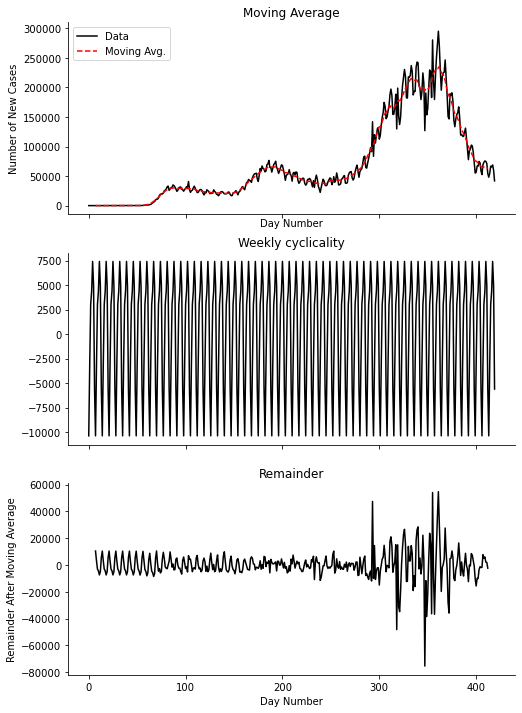

In [123]:
fig,ax = plt.subplots(3,1, sharex=True)
ax[0].plot(df_nc.index, df_nc.positiveIncrease, c='k', label='Data')
ax[0].plot(df_nc.index,df_nc.mv_avg, c='r', linestyle='--', label='Moving Avg.')
ax[0].set_xlabel('Day Number')
ax[0].set_ylabel('Number of New Cases')
#ax[0].vlines(100, ax[0].get_ylim()[0],  ax[0].get_ylim()[1], linestyles='dashed', colors=['gray'])
#ax[0].vlines(190, ax[0].get_ylim()[0],  ax[0].get_ylim()[1], linestyles='dashed', colors=['gray'])
ax[0].legend()
ax[0].set_title('Moving Average')
ax[1].plot(df_nc.index, df_nc.cycl, c='k')
ax[1].set_title('Weekly cyclicality')
ax[2].plot(df_nc.index, df_nc.R2,c='k')
ax[2].set_xlabel('Day Number')
ax[2].set_ylabel('Remainder After Moving Average')
ax[2].set_title('Remainder')
for i in range(len(ax)):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
fig.set_size_inches(8,12)
plt.show()